<a href="https://colab.research.google.com/github/kasier48/DeepLearning/blob/main/AI_Pratice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1주차] 기본과제: MNIST를 분류 모델로 학습하기

- [ ]  Test data 준비하기
    - Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
    - Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
        - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.
- [ ]  `nn.CrossEntropyLoss` 적용하기
    - 현재 코드는 regression model을 구현한 상태로, MSE를 loss로 사용하고 있습니다.
    - 하지만 MNIST와 같은 분류 문제에서는 MSE는 적합하지 않습니다.
        - MSE에 따르면 1에 해당하는 손글씨 이미지는 7에 해당하는 손글씨 이미지보다 0에 해당하는 손글씨 이미지가 더 가깝게 여겨집니다.
        - 하지만 1은 실제로 0보다 7과 더 비슷하게 생겼습니다.
    - 일반적으로 분류 문제는 MSE 대신 cross entropy loss를 사용합니다.
    - PyTorch에서의 [cross entropy loss 문서](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 또는 [웹 자료](https://uumini.tistory.com/54)들을 통해 이해한 후, MSE를 대체하는 코드를 구현하시면 됩니다.
        - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.
- [ ]  학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
    - 다음 조건들 아래에서 학습을 진행하면 됩니다.
        - `n_epochs`=100, `batch_size`=256, `lr`=0.001.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 134MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 16.4MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 44.9MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.70MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



train_dataset len: 60000
train size: torch.Size([1, 28, 28])
Epoch:   0 | Lost: 529.1397929191589
Epoch:   1 | Lost: 505.71373891830444
Epoch:   2 | Lost: 479.8324420452118
Epoch:   3 | Lost: 448.8142170906067
Epoch:   4 | Lost: 412.0516628026962
Epoch:   5 | Lost: 371.1462994813919
Epoch:   6 | Lost: 329.9600328207016
Epoch:   7 | Lost: 291.8109072446823
Epoch:   8 | Lost: 259.1923741698265
Epoch:   9 | Lost: 232.4509318470955


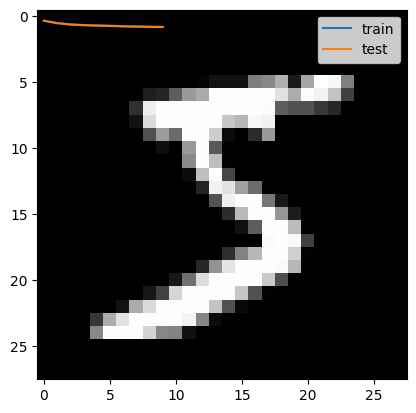

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

device = torch.device('cuda')

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

# [MYCODE] 데이터 전처리: 이미지를 텐서로 변환하고 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST의 평균과 표준편차 적용
])

# [MYCODE] MNIST 데이터셋 불러오기
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"train_dataset len: {len(train_dataset)}")
print(f"train size: {train_dataset[0][0].shape}")
plt.imshow(train_dataset[0][0][0], cmap='gray')

batch_size = 256

# [MYCODE] train, test에 대한 배치 사이즈에 따른 dataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_dim)
        self.fc2 = nn.Linear(n_dim, n_dim)

        # [MYCODE] 0 ~ 9의 이미지를 분류하기 때문에 10으로 설정
        self.fc3 = nn.Linear(n_dim, 10)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model(1 * 28 * 28, 1024).to(device)

lr = 0.001

# [MYCODE] 다중 클래스 분류에서 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# [MYCODE] 정확도를 매 epoch 타이밍 때 마다 리스트에 저장
train_acc_list = []
test_acc_list = []
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch:3d} | Lost: {running_loss}")

    train_acc = accuracy(model, dataloader=train_loader)
    train_acc_list.append(train_acc)

    test_acc = accuracy(model, dataloader=test_loader)
    test_acc_list.append(test_acc)

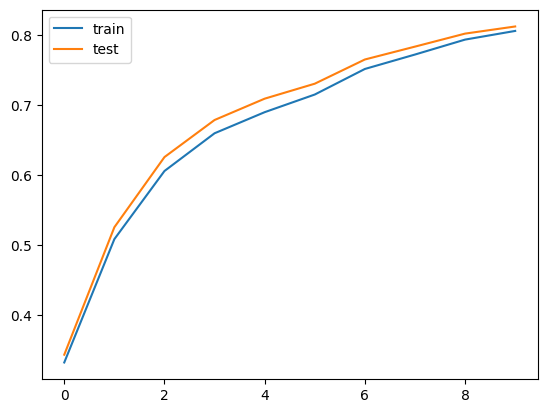

In [2]:
# [MYCODE] train, test 정확도가 얼마나 차이 나는지 그래프로 표현
plot_acc(train_accs=train_acc_list, test_accs=test_acc_list)